**Install Dependencies for running ollama on colab:**

In [ ]:
!sudo apt-get install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh # download ollama api
from IPython.display import clear_output

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpci3 pci.ids
The following NEW packages will be installed:
  libpci3 pci.ids pciutils
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 343 kB of archives.
After this operation, 1,581 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pci.ids all 0.0~2022.01.22-1 [251 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpci3 amd64 1:3.7.0-6 [28.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 pciutils amd64 1:3.7.0-6 [63.6 kB]
Fetched 343 kB in 1s (258 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initializ

**Running olaama foe models:**

In [ ]:
import os
import threading
import subprocess
import requests
import json
def ollama():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])

ollama_thread = threading.Thread(target=ollama)
ollama_thread.start()



**pull qwen2.5-coder:7b using ollama pull command:**

In [ ]:
from IPython.display import clear_output
# !ollama pull llama3.1:8b
!ollama pull qwen2.5-coder:7b
clear_output()

**Install dependencies for swarm franework**

In [ ]:
!pip install openai
!pip install git+https://github.com/openai/swarm.git

**calling local downloded qwen 2.5-coder:7b for infrencing in open ai client**

In [ ]:
import openai
from google.colab import userdata

#model = "meta/llama-3.1-405b-instruct"
#model = "llama-3.1-70b-versatile"
#model = "llama-3.2-90b-text-preview"

# model = "llama3-groq-70b-8192-tool-use-preview"

#groq Client
# llm_client = openai.OpenAI(
#   base_url="https://api.groq.com/openai/v1",
#   api_key=userdata.get('GROQ_API_KEY'),
# )

model="qwen2.5-coder:7b"
#ollama local client
ollama_client = openai.OpenAI(
    base_url="http://localhost:11434/v1",
    api_key="ollama"
)


In [ ]:
from swarm import Swarm, Agent

swarm_client = Swarm(client=ollama_client)

agent = Agent(
    name="Agent",
    instructions="You are a helpful agent.",
    model=model,
    tool_choice="auto"
)

messages = [{"role": "user", "content": "Hi!"}]
response = swarm_client.run(agent=agent, messages=messages)

print(response.messages[-1]["content"])


Hello! How can I assist you today?


**Creating sql agent that take user query and give answer from database**

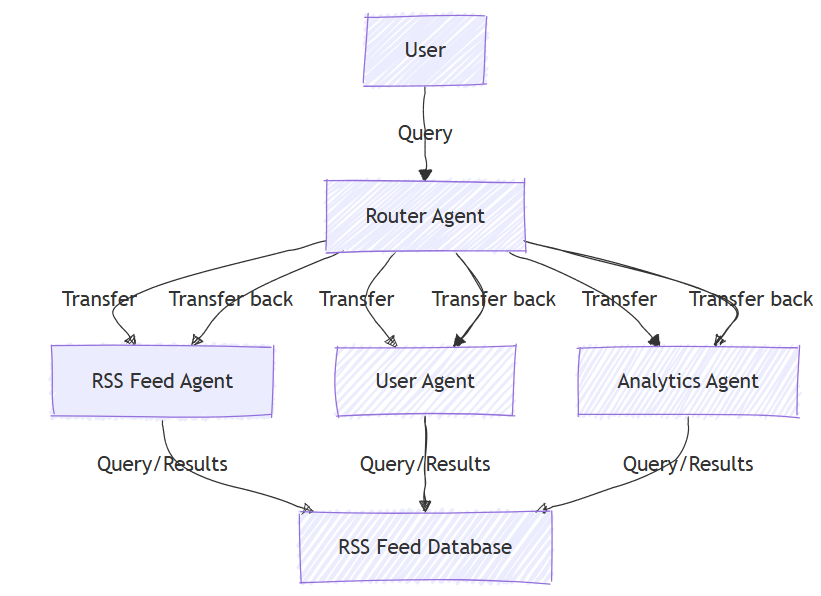

**Defines execute_sql_script function:**

Opens and reads an SQL file (script_file).
Splits the file content by ; to get individual SQL statements.
Executes each statement on the database cursor.

**Main process (main function)**:

*  **Connects to the database:** Creates a connection to an SQLite database file named rss-feed-database.db.
*  **Creates tables:** Runs SQL commands from ai-news-complete-tables.sql to create tables needed for the AI RSS Feed system.
*  **Inserts mock data:** Executes SQL commands in ai-news-complete-mock-data.sql to populate tables with example data.
*  **Validates data:** Queries the rss_feeds table and prints each record to verify successful insertion.
*  **Closes the connection:** Closes the database connection to save resources.

In [ ]:
import sqlite3

"""
This script is used to create a SQLlite database, add tables
to it, and insert mock data, all for the OpenAI Swarm demonstration
with the other Python script in this directory.

Simply run this script with the command:

python load_sql_data.py

And then you will have a database loaded and ready to use
with the agent swarm!
"""

def execute_sql_script(cursor, script_file):
    # Opens the .sql file given as script_file
    with open(script_file, 'r') as sql_file:
        sql_script = sql_file.read()

    # Gets all the sql commands and executes them one at a time
    statements = sql_script.split(';')
    for statement in statements:
        if statement.strip():
            cursor.execute(statement)

def main():
    # Connect to the database
    conn = sqlite3.connect('rss-feed-database.db')
    cursor = conn.cursor()

    # Execute SQL script to create tables for the AI RSS Feed system
    execute_sql_script(cursor, 'ai-news-complete-tables.sql')
    conn.commit()

    # Execute SQL script to insert mock data for the AI RSS Feed system
    execute_sql_script(cursor, 'ai-news-complete-mock-data.sql')
    conn.commit()

    # Query table to make sure things are looking good
    cursor.execute("SELECT * FROM rss_feeds")
    feeds = cursor.fetchall()
    for feed in feeds:
        print(feed)

    # Close the connection
    conn.close()

if __name__ == "__main__":
    main()

(1, 'AI Daily', 'https://ai-daily.com/feed', 'Daily AI news and updates', 'https://ai-daily.com', 'en')
(2, 'ML Weekly', 'https://mlweekly.com/rss', 'Weekly roundup of machine learning news', 'https://mlweekly.com', 'en')
(3, 'IA Nouvelles', 'https://ia-nouvelles.fr/flux', "Actualités sur l'intelligence artificielle en français", 'https://ia-nouvelles.fr', 'fr')
(4, 'Data Science Digest', 'https://datasciencedigest.com/feed', 'Comprehensive coverage of data science topics', 'https://datasciencedigest.com', 'en')
(5, 'AI Ethics Blog', 'https://aiethicsblog.org/rss', 'Exploring ethical implications of AI', 'https://aiethicsblog.org', 'en')


**Agents Setup: Creates four specialized agents:**

*  **Router Agent:** Routes user queries to the appropriate agent based on content.
*  **RSS Feed Agent:** Handles queries related to RSS feed data with an enthusiastic tone.
*  **User Agent:** Manages queries related to user data.
*  **Analytics Agent:** Provides analytical insights with high accuracy.
*  **SQL Query Execution:** Defines a function run_sql_select_statement to execute and format SQL SELECT statements.

**Agent Transfer Functions:** Allows agents to route queries back to the Router Agent if the query is outside their domain.

In [ ]:

from swarm import Agent
import sqlite3
import os


conn = sqlite3.connect('rss-feed-database.db')
cursor = conn.cursor()

with open("ai-news-complete-tables.sql", "r") as table_schema_file:
    table_schemas = table_schema_file.read()

def run_sql_select_statement(sql_statement):
    """Executes a SQL SELECT statement and returns the results of running the SELECT. Make sure you have a full SQL SELECT query created before calling this function."""
    print(f"Executing SQL statement: {sql_statement}")
    cursor.execute(sql_statement)
    records = cursor.fetchall()

    if not records:
        return "No results found."

    # Get column names
    column_names = [description[0] for description in cursor.description]

    # Calculate column widths
    col_widths = [len(name) for name in column_names]
    for row in records:
        for i, value in enumerate(row):
            col_widths[i] = max(col_widths[i], len(str(value)))

    # Format the results
    result_str = ""

    # Add header
    header = " | ".join(name.ljust(width) for name, width in zip(column_names, col_widths))
    result_str += header + "\n"
    result_str += "-" * len(header) + "\n"

    # Add rows
    for row in records:
        row_str = " | ".join(str(value).ljust(width) for value, width in zip(row, col_widths))
        result_str += row_str + "\n"

    return result_str

def get_sql_router_agent_instructions():
    return """You are an orchestrator of different SQL data experts and it is your job to
    determine which of the agent is best suited to handle the user's request,
    and transfer the conversation to that agent."""

def get_sql_agent_instructions():
    return f"""You are a SQL expert who takes in a request from a user for information
    they want to retrieve from the DB, creates a SELECT statement to retrieve the
    necessary information, and then invoke the function to run the query and
    get the results back to then report to the user the information they wanted to know.

    Here are the table schemas for the DB you can query:

    {table_schemas}

    Write all of your SQL SELECT statements to work 100% with these schemas and nothing else.
    You are always willing to create and execute the SQL statements to answer the user's question.
    """


sql_router_agent = Agent(
    name="Router Agent",
    instructions=get_sql_router_agent_instructions(),
    model=model,
    tool_choice="auto"

)
rss_feed_agent = Agent(
    name="RSS Feed Agent",
    instructions=get_sql_agent_instructions() + "\n\nHelp the user with data related to RSS feeds. Be super enthusiastic about how many great RSS feeds there are in every one of your responses.",
    functions=[run_sql_select_statement],
    model=model,
    tool_choice="auto"

)
user_agent = Agent(
    name="User Agent",
    instructions=get_sql_agent_instructions() + "\n\nHelp the user with data related to users.",
    functions=[run_sql_select_statement],
    model=model,
    tool_choice="auto"

)
analytics_agent = Agent(
    name="Analytics Agent",
    instructions=get_sql_agent_instructions() + "\n\nHelp the user gain insights from the data with analytics. Be super accurate in reporting numbers and citing sources.",
    functions=[run_sql_select_statement],
    model=model,
    tool_choice="auto"
)


def transfer_back_to_router_agent(**kwargs):
    """Call this function if a user is asking about data that is not handled by the current agent."""
    return sql_router_agent

def transfer_to_rss_feeds_agent(**kwargs):
    return rss_feed_agent

def transfer_to_user_agent(**kwargs):
    return user_agent

def transfer_to_analytics_agent(**kwargs):
    return analytics_agent



sql_router_agent.functions = [transfer_to_rss_feeds_agent, transfer_to_user_agent, transfer_to_analytics_agent]
rss_feed_agent.functions.append(transfer_back_to_router_agent)
user_agent.functions.append(transfer_back_to_router_agent)
analytics_agent.functions.append(transfer_back_to_router_agent)

ModuleNotFoundError: No module named 'swarm'

**For streamimg the swram client**

In [ ]:
def process_and_print_streaming_response(response):
    content = ""
    last_sender = ""

    for chunk in response:
        if "sender" in chunk:
            last_sender = chunk["sender"]

        if "content" in chunk and chunk["content"] is not None:
            if not content and last_sender:
                print(f"\033[94m{last_sender}:\033[0m", end=" ", flush=True)
                last_sender = ""
            print(chunk["content"], end="", flush=True)
            content += chunk["content"]

        if "tool_calls" in chunk and chunk["tool_calls"] is not None:
            for tool_call in chunk["tool_calls"]:
                f = tool_call["function"]
                name = f["name"]
                if not name:
                    continue
                print(f"\033[94m{last_sender}: \033[95m{name}\033[0m()")

        if "delim" in chunk and chunk["delim"] == "end" and content:
            print()  # End of response message
            content = ""

        if "response" in chunk:
            return chunk["response"]


def pretty_print_messages(messages) -> None:
    for message in messages:
        if message["role"] != "assistant":
            continue

        # print agent name in blue
        print(f"\033[94m{message['sender']}\033[0m:", end=" ")

        # print response, if any
        if message["content"]:
            print(message["content"])

        # print tool calls in purple, if any
        tool_calls = message.get("tool_calls") or []
        if len(tool_calls) > 1:
            print()
        for tool_call in tool_calls:
            f = tool_call["function"]
            name, args = f["name"], f["arguments"]
            arg_str = json.dumps(json.loads(args)).replace(":", "=")
            print(f"\033[95m{name}\033[0m({arg_str[1:-1]})")

def run_demo_loop(
    starting_agent, context_variables=None, stream=False, debug=False
) -> None:
    client = Swarm(client=ollama_client)
    print("Starting Ollama Swarm CLI 🐝")

    messages = []
    agent = starting_agent

    while True:
        user_input = input("\033[90mUser\033[0m: ")
        if "exit" in user_input:
            print("Good bye")
            break
        messages.append({"role": "user", "content": user_input})

        response = client.run(
            agent=agent,
            messages=messages,
            context_variables=context_variables or {},
            stream=stream,
            debug=debug,
        )

        if stream:
            response = process_and_print_streaming_response(response)
        else:
            pretty_print_messages(response.messages)

        messages.extend(response.messages)
        agent = response.agent


**stream on run**

In [ ]:
if __name__ == "__main__":
    run_demo_loop(sql_router_agent)

Starting Ollama Swarm CLI 🐝
User: give me latest top 5 ai news
Executing SQL statement: SELECT r.id AS rss_feed_id, r.name AS rss_feed_name, i.id AS item_id, i.title AS item_title, i.link AS item_link, i.description AS item_description, i.published_date AS published_date FROM rss_items i JOIN rss_feeds r ON i.rss_feed_id = r.id WHERE r.name LIKE '%AI%' OR r.description LIKE '%AI%' ORDER BY published_date DESC LIMIT 5
Router Agent: transfer_to_rss_feeds_agent("kwargs"= "AI technology news")
RSS Feed Agent: run_sql_select_statement("sql_statement"= "SELECT r.id AS rss_feed_id, r.name AS rss_feed_name, i.id AS item_id, i.title AS item_title, i.link AS item_link, i.description AS item_description, i.published_date AS published_date FROM rss_items i JOIN rss_feeds r ON i.rss_feed_id = r.id WHERE r.name LIKE '%AI%' OR r.description LIKE '%AI%' ORDER BY published_date DESC LIMIT 5")
RSS Feed Agent: Sure! Based on the query you've provided, here are the latest top 5 AI news stories from differ

KeyboardInterrupt: Interrupted by user